# Excercises

In [1]:
# imports
from IPython.display import Image
from os import getcwd, path
import numpy as np
from math import fabs, pi, sin, cos
import matplotlib.pyplot as plt

In [2]:
# directories
cw_dir = getcwd()
image_dir = path.join(cw_dir, 'Images')

## Excercise 1

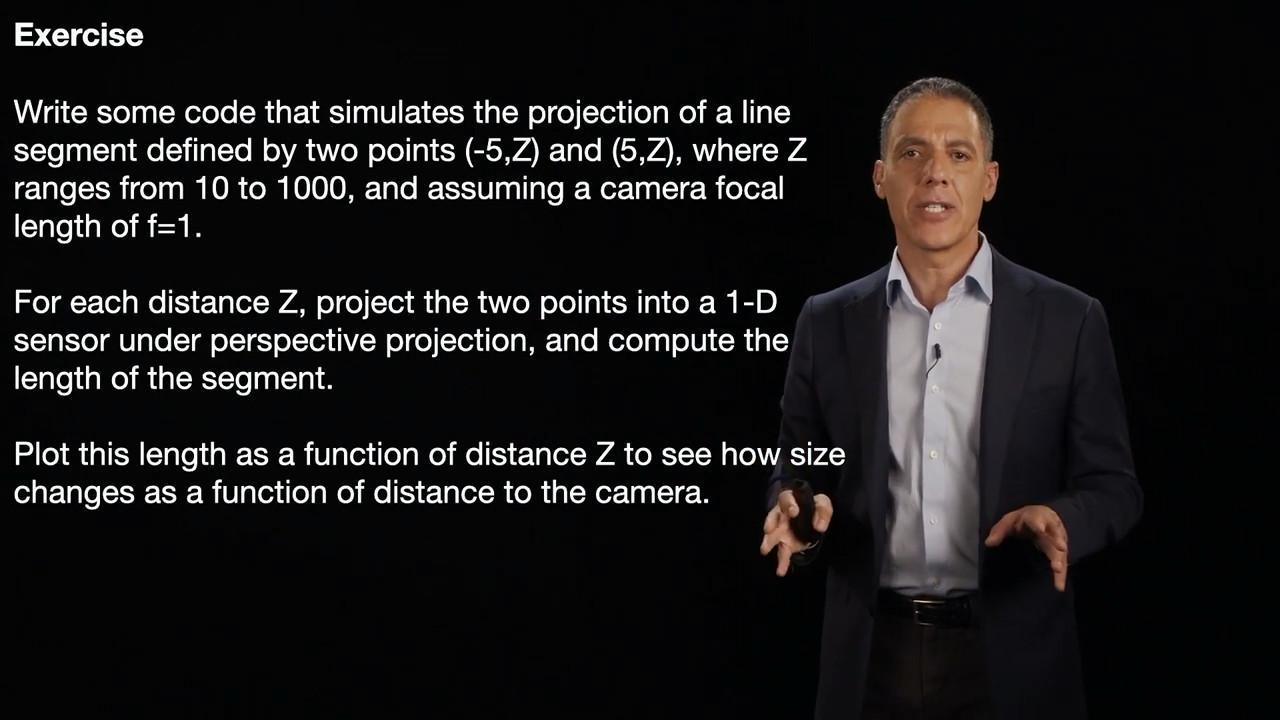

In [3]:
# question
Image(path.join(image_dir, 'Excercise1.jpg'))

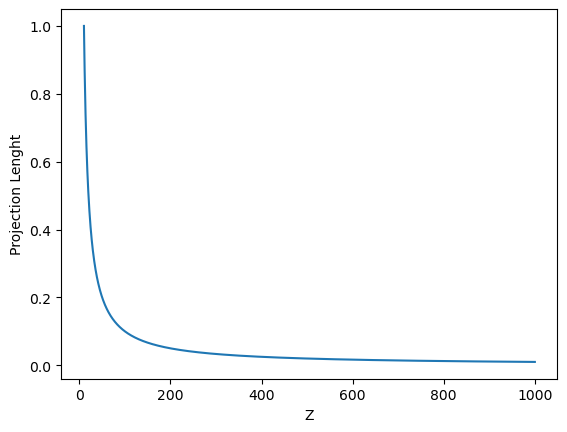

In [4]:
# answer
focal_length = 1

z_start = 10
z_stop = 1000
step_per_unit = 2
samples = (z_stop - z_start) * step_per_unit
Z = np.linspace(z_start, z_stop, samples, endpoint=True)

x_start = 5
x_stop = -5

p_lengths = []
for z_sample in Z:
    P1 = (x_start, z_sample)
    P2 = (x_stop, z_sample)

    # calculate coordinate on sensor
    p1 = - focal_length * P1[0] / P1[1]
    p2 = - focal_length * P2[0] / P2[1]

    # calculate projection length
    p_length = fabs(p2 - p1)
    p_lengths.append(p_length)

plt.plot(Z, p_lengths)
plt.xlabel('Z')
plt.ylabel('Projection Lenght')
plt.show()

## Excercise 2

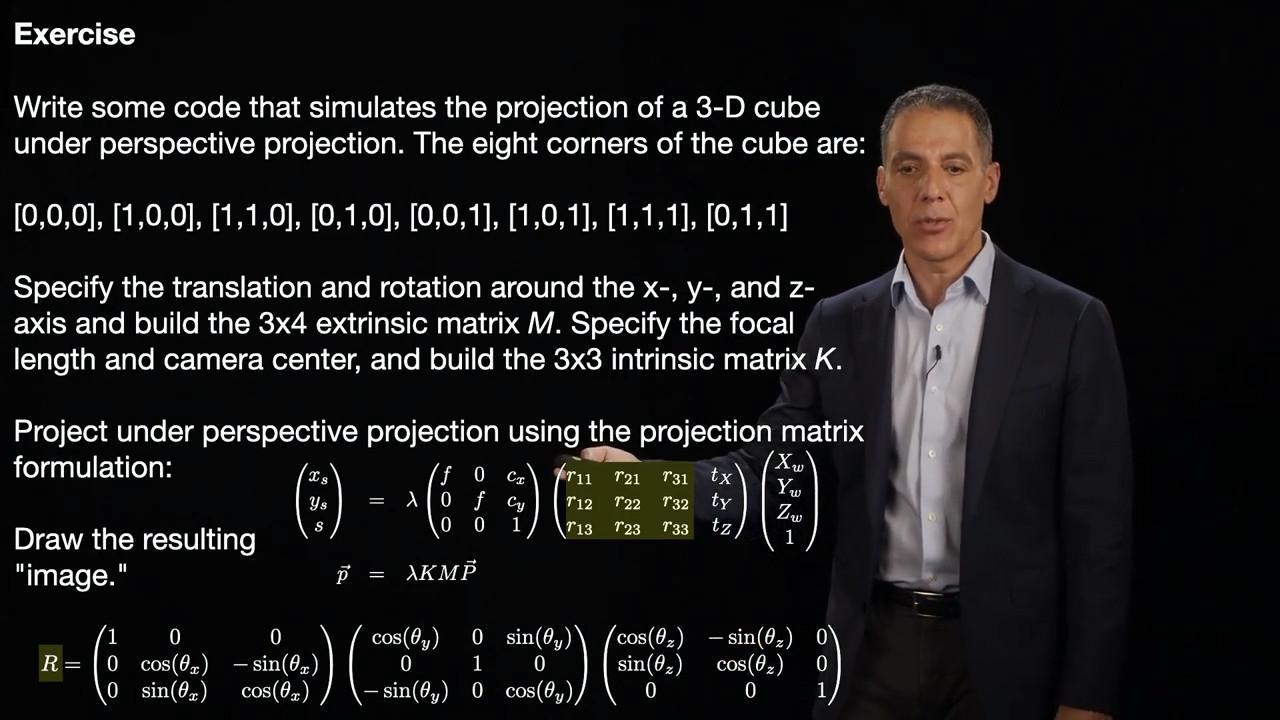

In [5]:
# question
Image(path.join(image_dir, 'Excercise2.jpg'))

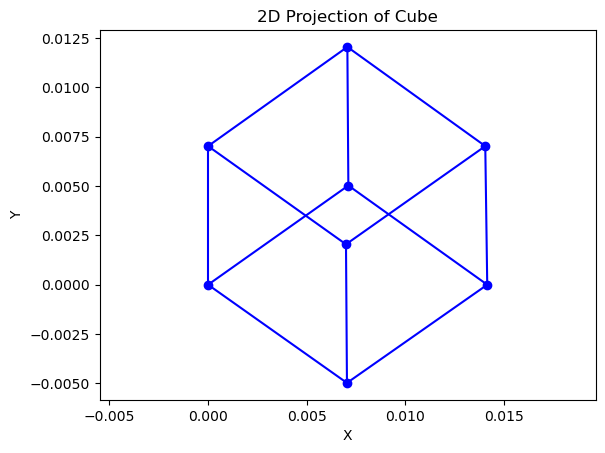

In [6]:
# answer
cube = np.array([[0,0,0], [1,0,0], [1,1,0], [0,1,0], [0,0,1], [1,0,1], [1,1,1], [0,1,1]]) # eight corners of the cube

lamda = 1 # pixel/unit

f = 1 # focal length
c_x, c_y = 0, 0 # origin offset
K = np.array([[f, 0, c_x], [0, f, c_y], [0, 0, 1]]) # intrinsic matrix

# rotation around each axis
theta_x = pi/4
theta_y = pi/4
theta_z = 0

# rotation matrix for each axis
R_x = np.array([[1,0,0], [0, cos(theta_x), -sin(theta_x)], [0, sin(theta_x), cos(theta_x)]])
R_y = np.array([[cos(theta_y), 0, sin(theta_y)], [0,1,0], [-sin(theta_y), 0, cos(theta_y)]])
R_z = np.array([[cos(theta_z), -sin(theta_z), 0], [sin(theta_z), cos(theta_z), 0], [0,0,1]])

# 3x3 rotation matrix 
R = R_x @ R_y @ R_z

# translation vector
t_x, t_y, t_z = 0, 0, 100
t_vec = np.array([[t_x, t_y, t_z]]).T

# construct extrinsic matrix
M = np.hstack((R, t_vec))

# calculate projection for each corner in cube
points = []
for corner in cube:
    X_w, Y_w, Z_w = corner
    P = np.array([[X_w, Y_w, Z_w, 1]]).T # Point in homogeneous world coordinates
    p = lamda * K @ M @ P # point in homogeneous camera coordinates
    x_s, y_s, s = p
    x = x_s/s
    y = y_s/s
    points.append((x,y))

vertices = points[0:]

# define the edges connecting the vertices
edges = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # bottom face
    (4, 5), (5, 6), (6, 7), (7, 4),  # top face
    (0, 4), (1, 5), (2, 6), (3, 7)   # vertical edges
]

# plot the edges
for edge in edges:
    x_coords = [vertices[edge[0]][0], vertices[edge[1]][0]]
    y_coords = [vertices[edge[0]][1], vertices[edge[1]][1]]
    plt.plot(x_coords, y_coords, color='blue')

# highlight the vertices
x, y = zip(*vertices)
plt.scatter(x, y, color='blue')

# customize the plot
plt.axis('equal')  # equal aspect ratio for proper scaling
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Projection of Cube")
plt.show()

## Excercise 3

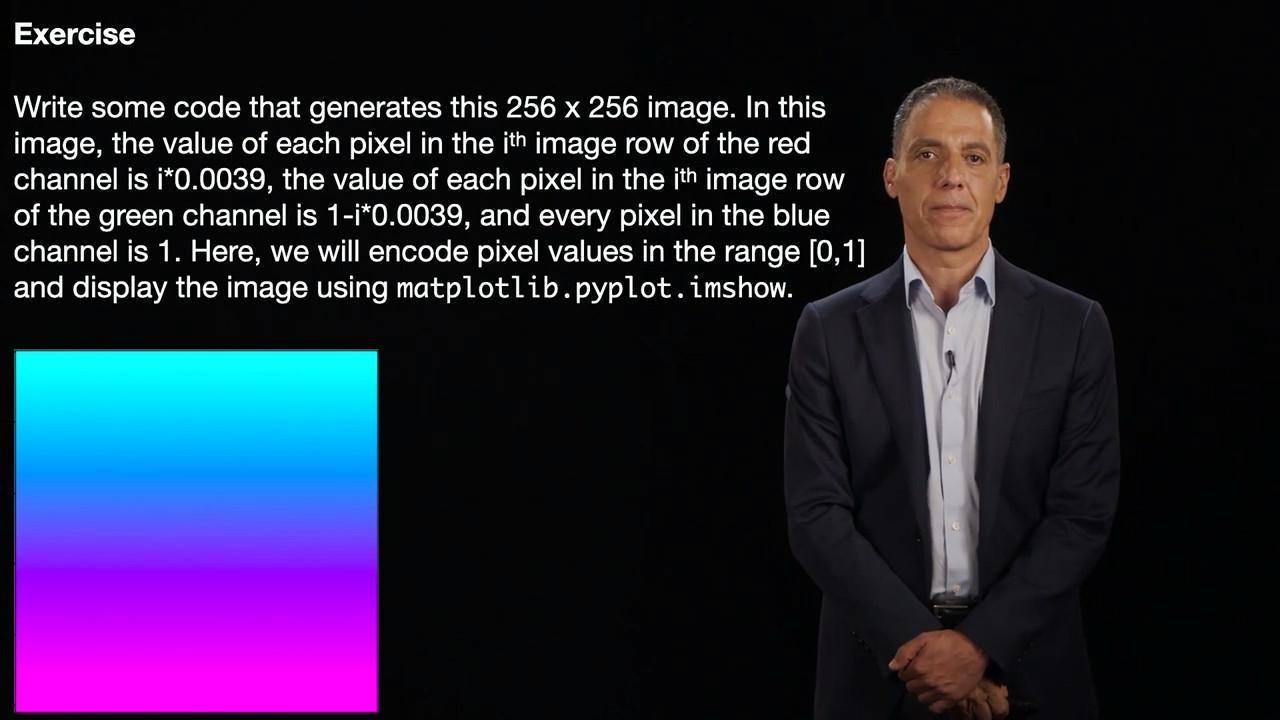

In [7]:
# question
Image(path.join(image_dir, 'Excercise3.jpg'))

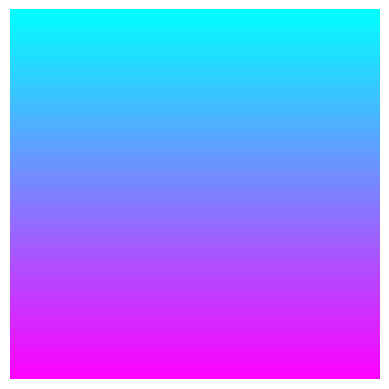

In [8]:
# answer
dim = (256, 256) # dimension of the image

# initialize each color channel
r_channel = np.zeros(dim)
g_channel = np.zeros(dim)
b_channel = np.zeros(dim)

# assign each pixel value
for i in range(dim[0]): # for each row in image
    r_channel[i,:] = i * 0.0039
    g_channel[i,:] = 1 - i * 0.0039
    b_channel[i,:] = 1

# crate RGB image
rgb_image = np.stack((r_channel, g_channel, b_channel), axis=-1)

# display the RGB image
plt.imshow(rgb_image)
plt.axis('off')  # hide the axis for a cleaner display
plt.show()